In [8]:
import json
import os
import numpy as np

def load_existing_results(file_path="forecasting_results.json"):
    """
    Load existing results from a JSON file.
    Returns an empty dictionary if the file doesn't exist.
    """
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            return json.load(f)
    return {}


def save_results_to_json(data, file_path="forecasting_results.json"):
    """
    Save the results dictionary to a JSON file, handling NumPy data types.
    """

    # Handle NumPy data types (recursive conversion)
    def convert_numpy(obj):
        if isinstance(obj, dict):
            return {k: convert_numpy(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy(i) for i in obj]
        elif isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert arrays to lists
        else:
            return obj

    # Convert data and save to JSON
    data = convert_numpy(data)
    with open(file_path, "w") as f:
        json.dump(data, f, indent=4)
    print(f"✅ Results saved to {file_path}")



def store_results(dataset_name, horizons, horizon_value, experiment_type, backbone, mae_result, file_path="forecasting_results.json"):
    """
    Store MAE results for a given experiment type (stl_mae, mtl_mae, global_mae) per horizon.

    Args:
    - dataset_name (str): Name of the dataset (e.g., 'Solar', 'Air Quality').
    - horizons (list): List of horizon values (e.g., [1, 2, 4, 8, 16]).
    - horizon_value (int): The horizon corresponding to the mae_result provided.
    - experiment_type (str): One of ['stl_mae', 'mtl_mae', 'global_mae'].
    - backbone (str): Model backbone name (e.g., 'Deep_LSTM', 'simple_transformer').
    - mae_result (list): MAE values for the current horizon (list of floats).
    - file_path (str): JSON file to store the results.

    Returns:
    - None
    """
    # Load existing results
    results_dict = load_existing_results(file_path)

    # Create dataset entry if it doesn't exist
    dataset_key = f"{dataset_name}_{backbone}"
    if dataset_key not in results_dict:
        results_dict[dataset_key] = {
            "horizons": horizons,
            "mtl": [[] for _ in horizons],
            "global": [[] for _ in horizons],
            "independent": [[] for _ in horizons]
        }

    # Find index for the given horizon
    try:
        horizon_index = horizons.index(horizon_value)
    except ValueError:
        raise ValueError(f"⚠️ Horizon value {horizon_value} not found in {horizons}.")

    # Append the mae_result to the correct horizon
    results_dict[dataset_key][experiment_type][horizon_index].extend(mae_result)

    # Save updated results
    save_results_to_json(results_dict, file_path)

In [9]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import dateutil.parser
import matplotlib.pyplot as plt


class BalancedDataLoaderIterator:
    '''
    This class iterates over multiple PyTorch dataloaders in a balanced way, 
    ensuring that all dataloaders contribute to the training equally. 
    It uses random sampling to choose from multiple dataloaders while 
    handling different dataset lengths.
    '''
    def __init__(self, dataloaders):
        self.dataloaders = dataloaders

        self.num_dataloaders = len(dataloaders)

        max_length = max(len(dataloader) for dataloader in dataloaders)

        length_list = [len(dataloader) for dataloader in dataloaders]
        print("data loader length:", length_list)
        print("max dataloader length:", max_length,
              "epoch iteration:", max_length * self.num_dataloaders)
        self.total_length = max_length * self.num_dataloaders
        self.current_iteration = 0
        self.probabilities = torch.ones(
            self.num_dataloaders, dtype=torch.float) / self.num_dataloaders

    def __iter__(self):
        self.iterators = [iter(dataloader) for dataloader in self.dataloaders]
        self.current_iteration = 0
        return self

    def __next__(self):
        if self.current_iteration >= self.total_length:
            raise StopIteration

        chosen_index = torch.multinomial(self.probabilities, 1).item()
        try:
            sample = next(self.iterators[chosen_index])
        except StopIteration:
            self.iterators[chosen_index] = iter(self.dataloaders[chosen_index])
            sample = next(self.iterators[chosen_index])

        self.current_iteration += 1
        return sample, chosen_index

    def __len__(self):
        return self.total_length

def df_to_X_y(df, features, target, window_size=32, horizon=1):
    if target not in features:
        features = [target] + features

    data = df[features].to_numpy()
    target_data = df[target].to_numpy()

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])
        y.append(target_data[i + window_size: i + window_size + horizon])

    return np.array(X), np.array(y)

def load_all_sites_balanced(
    base_dir='../processed_ds/air_quality_cluster/', 
    features= [],
    target = '',
    window_size=32, 
    horizon=16, 
    batch_size=16,
    min_date=None, 
    max_date=None,
    device="cpu"
):
    """
    Loads and preprocesses time series data for all sites, ensuring balanced training across sites.

    Args:
    - base_dir (str): Path to the directory containing site folders.
    - window_size (int): Number of past time steps for input.
    - horizon (int): Number of future steps to predict.
    - batch_size (int): Batch size for DataLoader.
    - min_date (str or datetime, optional): Start date for filtering data.
    - max_date (str or datetime, optional): End date for filtering data.

    Returns:
    - balanced_train_loader: Balanced DataLoader across all sites for training.
    - site_val_loaders: Dictionary of validation DataLoaders per site.
    - site_test_loaders: Dictionary of test DataLoaders per site.
    """
    
    # Get the list of site directories
    site_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    site_dirs.sort()

    train_loaders = []
    site_val_loaders = {}
    site_test_loaders = {}

    for site in site_dirs:
        site_path = os.path.join(base_dir, site)
        csv_files = [f for f in os.listdir(site_path) if f.endswith('.csv')]
        csv_files.sort()

        for csv_file in csv_files:
            file_path = os.path.join(site_path, csv_file)
            df_site = pd.read_csv(file_path)

            # Convert date column to datetime if it exists
            if 'date' in df_site.columns:
                df_site['date'] = pd.to_datetime(df_site['date'])

                # Filter based on min_date and max_date
                if min_date:
                    min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
                    df_site = df_site[df_site['date'] >= min_date]

                if max_date:
                    max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
                    df_site = df_site[df_site['date'] <= max_date]

                # Drop date column after filtering
                df_site.drop(columns=['date'], inplace=True)

            # Perform 80-20 train-test split
            train_size = int(0.8 * len(df_site))
            train_df = df_site.iloc[:train_size]
            test_df = df_site.iloc[train_size:]

            # Split train_df further into Train (80%) and Validation (20%)
            val_size = int(0.2 * len(train_df))  # 16% of full dataset
            train_df, val_df = train_df.iloc[:-val_size], train_df.iloc[-val_size:]

            print(f"Site: {site} | Train: {len(train_df)} | Validation: {len(val_df)} | Test: {len(test_df)}")

            # Standardize data per site (avoid data leakage)
            train_mean, train_std = train_df.mean(), train_df.std()
            train_df = (train_df - train_mean) / (train_std + 1e-8)
            val_df = (val_df - train_mean) / (train_std + 1e-8)
            test_df = (test_df - train_mean) / (train_std + 1e-8)

            # Convert DataFrame to NumPy arrays for LSTM
            X_train, y_train = df_to_X_y(train_df, features, target, window_size, horizon)
            X_val, y_val = df_to_X_y(val_df,features, target ,window_size, horizon)
            X_test, y_test = df_to_X_y(test_df, features, target ,window_size, horizon)

            # Convert to PyTorch tensors
            # train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
            # val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
            # test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
            
            train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
            val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
            test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

            # Create DataLoaders
            train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
            val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
            test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

            # Store loaders for this site
            train_loaders.append(train_loader)
            site_val_loaders[site] = val_loader
            site_test_loaders[site] = test_loader

    # Create Balanced DataLoader for Training
    balanced_train_loader = BalancedDataLoaderIterator(train_loaders)

    return balanced_train_loader, site_val_loaders, site_test_loaders

# Base Architecture

In [19]:
# Imports
import torch, math
import numpy as np
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn.modules.transformer import TransformerEncoderLayer
from torch.optim.lr_scheduler import ExponentialLR
import os

# Positional Encoding - https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(1)].transpose(0, 1)
        return self.dropout(x)

# A forcasting model
class ForecastingModel(torch.nn.Module):
    def __init__(self, 
                 seq_len=200,
                 embed_size = 16,
                 num_features=8,
                 horizon=1,
                 nhead = 2,
                 dim_feedforward = 2048,
                 dropout = 0.1,
                 conv1d_emb = True, # Changed from True to False.
                 conv1d_kernel_size = 3,
                 device = "cuda"):
        super(ForecastingModel, self).__init__()

        # Set Class-level Parameters
        self.device = device
        self.conv1d_emb = conv1d_emb # Why Convolution????
        self.conv1d_kernel_size = conv1d_kernel_size
        self.seq_len = seq_len
        self.embed_size = embed_size

        # Input Embedding Component
        if conv1d_emb:
            if conv1d_kernel_size%2==0:
                raise Exception("conv1d_kernel_size must be an odd number to preserve dimensions.")
            self.conv1d_padding = conv1d_kernel_size - 1
            self.input_embedding  = nn.Conv1d(num_features, embed_size, kernel_size=conv1d_kernel_size)
        else: self.input_embedding  = nn.Linear(num_features, embed_size)

        # Positional Encoder Componet (See Code Copied from PyTorch Above)
        self.position_encoder = PositionalEncoding(d_model=embed_size, 
                                                   dropout=dropout,
                                                   max_len=seq_len)
        
        # Transformer Encoder Layer Component
        self.transformer_encoder = TransformerEncoderLayer(
            d_model = embed_size,
            nhead = nhead,
            dim_feedforward = dim_feedforward,
            dropout = dropout,
            batch_first = True
        )

        # Regression Component
        self.linear1 = nn.Linear(seq_len*embed_size, int(dim_feedforward))
        # self.linear2 = nn.Linear(int(dim_feedforward), int(dim_feedforward/2))
        # self.linear3 = nn.Linear(int(dim_feedforward/2), int(dim_feedforward/4))
        # self.linear4 = nn.Linear(int(dim_feedforward/4), int(dim_feedforward/16))
        # self.linear5 = nn.Linear(int(dim_feedforward/16), int(dim_feedforward/64))
        self.outlayer = nn.Linear(int(dim_feedforward), horizon)

        # Basic Components
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    # Model Forward Pass
    def forward(self, x):
        src_mask = self._generate_square_subsequent_mask()
        src_mask.to(self.device)
        if self.conv1d_emb: 
            x = F.pad(x, (0, 0, self.conv1d_padding, 0), "constant", -1)
            x = self.input_embedding(x.transpose(1, 2))
            x = x.transpose(1, 2)
        else: 
            x = self.input_embedding(x)
        x = self.position_encoder(x)
        x = self.transformer_encoder(x, src_mask=src_mask).reshape((-1, self.seq_len*self.embed_size))
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        # x = self.linear2(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        # x = self.linear3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        # x = self.linear4(x)
        # x = self.relu(x)
        x = self.dropout(x)
        # x = self.linear5(x)
        x = self.relu(x)
        return self.outlayer(x)
    
    # Function Copied from PyTorch Library to create upper-triangular source mask
    def _generate_square_subsequent_mask(self):
        return torch.triu(
            torch.full((self.seq_len, self.seq_len), float('-inf'), dtype=torch.float32, device=self.device),
            diagonal=1,
        )

In [23]:
def run_global_model_experiment():
    # --------------------------- #
    #    Run Experiments for All Sites #
    # --------------------------- #

    # Uncomment the desired dataset block:
    datasets = [
        {
            'name': 'Air Quality',
            'features': ['PM2.5', 'OT', 'PM10', 'NO2'],
            'target': 'PM2.5',
            'directory': "../processed_ds/air_quality_cluster/",
            'min_date': "2014-09-01",
            'max_date': "2014-11-12 19:00",
            'num_features': 4
        },
        {
            'name': 'Solar',
            'directory': "../processed_ds/solar/",
            'features': ['loc-1', 'loc-2', 'loc-3', 'loc-4'],
            'target': 'loc-1',
            'min_date': "2006-09-01",
            'max_date': "2006-09-08 4:50",
            'num_features': 4
        },
        {
            'name': 'Crypto',
            'directory': "../processed_ds/crypto-data/",
            'features': ['Open', 'High', 'Low', 'OT', 'Volume'],
            'target': 'OT',
            'min_date': "2018-04-01",
            'max_date': "2018-06-15",
            'num_features': 5
        },
        # {
        #     'name': 'Sales',
        #     'directory': "../processed_ds/stores_data/",
        #     'min_date': "2013-01-16",
        #     'max_date': "2015-07-31",
        #     'num_features': 7
        # }
    ]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    seq_len = 32
    embed_size = 128
    batch_size = 32
    num_epochs = 30
    dim_feedforward = 512
    dropout = 0.1

    # Horizons to run
    horizons = [1, 2, 4, 8, 16]

    # Output file for logging results
    output_file = "output_test.txt"
    with open(output_file, 'a') as f:
        f.write("\n================== Global Simple Transformer Experiment Results ==================\n")

    for dataset in datasets:
        site_directory = dataset["directory"]
        min_date = dataset["min_date"]
        max_date = dataset["max_date"]
        num_features = dataset["num_features"]

        print(f"\nRunning experiments for dataset: {site_directory}")
        with open(output_file, 'a') as f:
            f.write(f"\nDataset: {site_directory}\n")

        for horizon in horizons:  # Specific horizons
            print(f"\nStarting experiment for horizon: {horizon}")
            with open(output_file, 'a') as f:
                f.write(f"\n--- Horizon: {horizon} ---\n")

            # Load data
            balanced_train_loader, val_loaders, test_loaders = load_all_sites_balanced(
                base_dir=site_directory,
                features=dataset['features'],
                target=dataset['target'],
                window_size=seq_len,
                horizon=horizon,
                batch_size=batch_size,
                min_date=min_date,
                max_date=max_date,
                device=device
            )

            # Instantiate model
            model = ForecastingModel(
                seq_len=seq_len,
                embed_size=embed_size,
                num_features=num_features,
                horizon=horizon,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                device=device
            ).to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
            scheduler = ExponentialLR(optimizer, gamma=0.95)
            criterion = nn.MSELoss()

            train_losses, val_losses = [], []

            # Training
            model.train()
            for epoch in range(num_epochs):
                epoch_train_losses = []
                print(f"Epoch {epoch+1}/{num_epochs} for horizon {horizon}")
                for (batch, chosen_index) in balanced_train_loader:
                    batch_x, batch_y = batch
                    optimizer.zero_grad()
                    output = model(batch_x)
                    loss = criterion(output, batch_y)
                    loss.backward()
                    optimizer.step()
                    epoch_train_losses.append(loss.item())

                scheduler.step()
                avg_train_loss = np.mean(epoch_train_losses)
                train_losses.append(avg_train_loss)

                # Validation
                model.eval()
                running_val_loss, val_batches = 0.0, 0
                with torch.no_grad():
                    for site, val_loader in val_loaders.items():
                        for batch_x, batch_y in val_loader:
                            output = model(batch_x)
                            loss = criterion(output, batch_y)
                            running_val_loss += loss.item()
                            val_batches += 1

                avg_val_loss = running_val_loss / val_batches if val_batches > 0 else float('inf')
                val_losses.append(avg_val_loss)

                print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
                model.train()

            # Plot Loss Curves
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label="Train Loss")
            plt.plot(val_losses, label="Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("MSE Loss")
            plt.title(f"Train vs. Validation Loss (Horizon={horizon})")
            plt.legend()
            plt.show()

            # Evaluation on Test Data (MAE)
            model.eval()
            mae_criterion = nn.L1Loss()
            site_mae_list = []

            with torch.no_grad():
                for site, test_loader in test_loaders.items():
                    site_preds, site_targets = [], []
                    for batch_x, batch_y in test_loader:
                        preds = model(batch_x)
                        site_preds.append(preds.cpu())
                        site_targets.append(batch_y.cpu())
                    site_preds_cat = torch.cat(site_preds, dim=0)
                    site_targets_cat = torch.cat(site_targets, dim=0)
                    test_mae = mae_criterion(site_preds_cat, site_targets_cat)
                    site_mae_list.append(test_mae.item())
                    print(f"Site: {site}, Test MAE (Horizon {horizon}): {test_mae.item():.4f}")

                    # Append site-wise MAE to output.txt
                    with open(output_file, 'a') as f:
                        f.write(f"Site: {site}, Test MAE (Horizon {horizon}): {test_mae.item():.4f}\n")

            avg_mae = np.mean(site_mae_list)
            with open(output_file, 'a') as f:
                f.write(f"Site-wise MAE list (Horizon {horizon}): {site_mae_list}\n")
            print(f"\nAverage MAE across all sites (Horizon {horizon}): {avg_mae:.4f}")
            store_results(
                dataset_name=dataset['name'],
                horizons=[1,2,4,8,16],
                experiment_type='global',
                mae_result=site_mae_list,
                backbone='simple_transformer',
                horizon_value=horizon
            )
            # Append average MAE to output.txt
            with open(output_file, 'a') as f:
                f.write(f"Average MAE across all sites (Horizon {horizon}): {avg_mae:.4f}\n")


Running experiments for dataset: ../processed_ds/air_quality_cluster/

Starting experiment for horizon: 1
Site: site-1 | Train: 1119 | Validation: 279 | Test: 350
Site: site-10 | Train: 1119 | Validation: 279 | Test: 350
Site: site-11 | Train: 1119 | Validation: 279 | Test: 350
Site: site-12 | Train: 1119 | Validation: 279 | Test: 350
Site: site-2 | Train: 1119 | Validation: 279 | Test: 350
Site: site-3 | Train: 1119 | Validation: 279 | Test: 350
Site: site-4 | Train: 1119 | Validation: 279 | Test: 350
Site: site-5 | Train: 1119 | Validation: 279 | Test: 350
Site: site-6 | Train: 1119 | Validation: 279 | Test: 350
Site: site-7 | Train: 1119 | Validation: 279 | Test: 350
Site: site-8 | Train: 1119 | Validation: 279 | Test: 350
Site: site-9 | Train: 1119 | Validation: 279 | Test: 350
data loader length: [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]
max dataloader length: 33 epoch iteration: 396
Epoch 1/30 for horizon 1
Epoch 1 | Train Loss: 0.4771 | Val Loss: 0.8669
Epoch 2/30 for ho

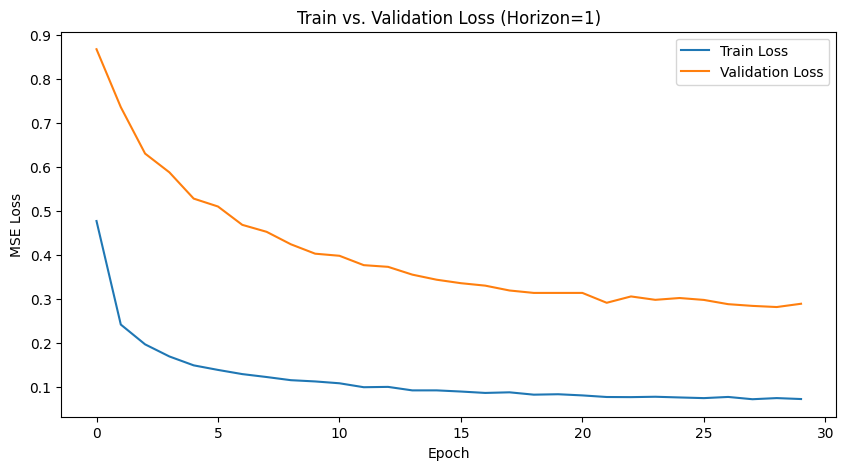

Site: site-1, Test MAE (Horizon 1): 0.1389
Site: site-10, Test MAE (Horizon 1): 0.2146
Site: site-11, Test MAE (Horizon 1): 0.1425
Site: site-12, Test MAE (Horizon 1): 0.2374
Site: site-2, Test MAE (Horizon 1): 0.1900
Site: site-3, Test MAE (Horizon 1): 0.1981
Site: site-4, Test MAE (Horizon 1): 0.1984
Site: site-5, Test MAE (Horizon 1): 0.1498
Site: site-6, Test MAE (Horizon 1): 0.1782
Site: site-7, Test MAE (Horizon 1): 0.1731
Site: site-8, Test MAE (Horizon 1): 0.2585
Site: site-9, Test MAE (Horizon 1): 0.2195

Average MAE across all sites (Horizon 1): 0.1916
✅ Results saved to forecasting_results.json

Starting experiment for horizon: 2
Site: site-1 | Train: 1119 | Validation: 279 | Test: 350
Site: site-10 | Train: 1119 | Validation: 279 | Test: 350
Site: site-11 | Train: 1119 | Validation: 279 | Test: 350
Site: site-12 | Train: 1119 | Validation: 279 | Test: 350
Site: site-2 | Train: 1119 | Validation: 279 | Test: 350
Site: site-3 | Train: 1119 | Validation: 279 | Test: 350
Site: 

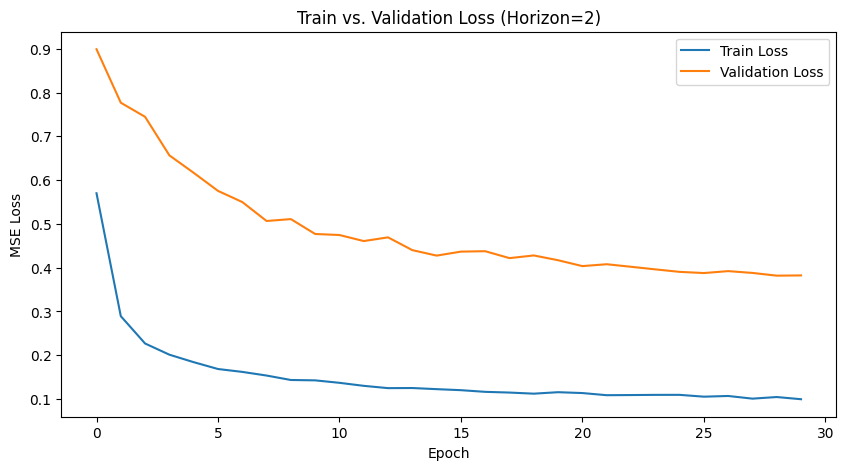

Site: site-1, Test MAE (Horizon 2): 0.1626
Site: site-10, Test MAE (Horizon 2): 0.2455
Site: site-11, Test MAE (Horizon 2): 0.1642
Site: site-12, Test MAE (Horizon 2): 0.2774
Site: site-2, Test MAE (Horizon 2): 0.1925
Site: site-3, Test MAE (Horizon 2): 0.1888
Site: site-4, Test MAE (Horizon 2): 0.2313
Site: site-5, Test MAE (Horizon 2): 0.1620
Site: site-6, Test MAE (Horizon 2): 0.2012
Site: site-7, Test MAE (Horizon 2): 0.1947
Site: site-8, Test MAE (Horizon 2): 0.2763
Site: site-9, Test MAE (Horizon 2): 0.2462

Average MAE across all sites (Horizon 2): 0.2119
✅ Results saved to forecasting_results.json

Starting experiment for horizon: 4
Site: site-1 | Train: 1119 | Validation: 279 | Test: 350
Site: site-10 | Train: 1119 | Validation: 279 | Test: 350
Site: site-11 | Train: 1119 | Validation: 279 | Test: 350
Site: site-12 | Train: 1119 | Validation: 279 | Test: 350
Site: site-2 | Train: 1119 | Validation: 279 | Test: 350
Site: site-3 | Train: 1119 | Validation: 279 | Test: 350
Site: 

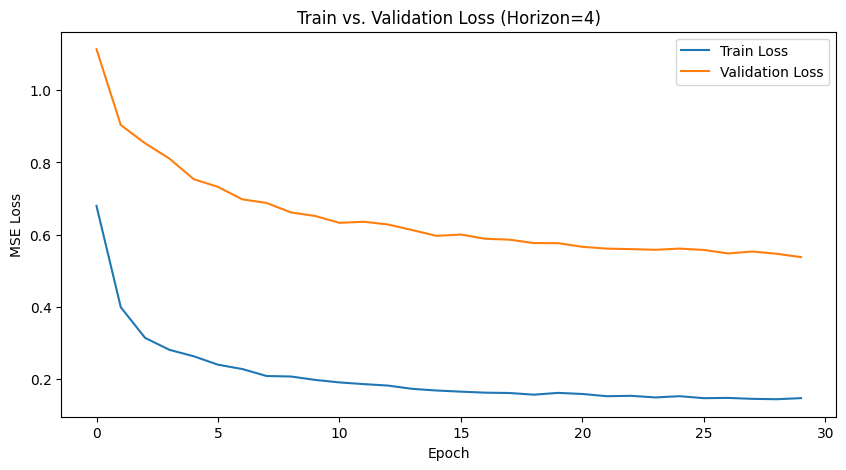

Site: site-1, Test MAE (Horizon 4): 0.2226
Site: site-10, Test MAE (Horizon 4): 0.3108
Site: site-11, Test MAE (Horizon 4): 0.2393
Site: site-12, Test MAE (Horizon 4): 0.3525
Site: site-2, Test MAE (Horizon 4): 0.2603
Site: site-3, Test MAE (Horizon 4): 0.2417
Site: site-4, Test MAE (Horizon 4): 0.2926
Site: site-5, Test MAE (Horizon 4): 0.2159
Site: site-6, Test MAE (Horizon 4): 0.2456
Site: site-7, Test MAE (Horizon 4): 0.2390
Site: site-8, Test MAE (Horizon 4): 0.3389
Site: site-9, Test MAE (Horizon 4): 0.3150

Average MAE across all sites (Horizon 4): 0.2729
✅ Results saved to forecasting_results.json

Starting experiment for horizon: 8
Site: site-1 | Train: 1119 | Validation: 279 | Test: 350
Site: site-10 | Train: 1119 | Validation: 279 | Test: 350
Site: site-11 | Train: 1119 | Validation: 279 | Test: 350
Site: site-12 | Train: 1119 | Validation: 279 | Test: 350
Site: site-2 | Train: 1119 | Validation: 279 | Test: 350
Site: site-3 | Train: 1119 | Validation: 279 | Test: 350
Site: 

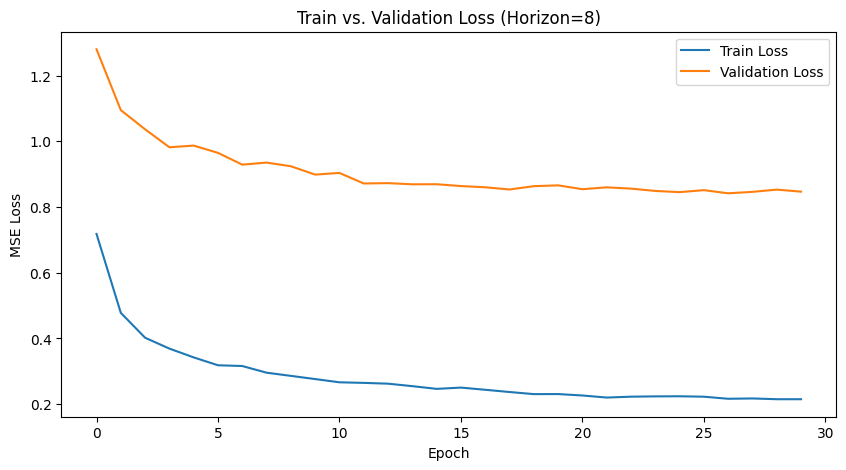

Site: site-1, Test MAE (Horizon 8): 0.2956
Site: site-10, Test MAE (Horizon 8): 0.4203
Site: site-11, Test MAE (Horizon 8): 0.3123
Site: site-12, Test MAE (Horizon 8): 0.4780
Site: site-2, Test MAE (Horizon 8): 0.2934
Site: site-3, Test MAE (Horizon 8): 0.2825
Site: site-4, Test MAE (Horizon 8): 0.3982
Site: site-5, Test MAE (Horizon 8): 0.3114
Site: site-6, Test MAE (Horizon 8): 0.3208
Site: site-7, Test MAE (Horizon 8): 0.3192
Site: site-8, Test MAE (Horizon 8): 0.4467
Site: site-9, Test MAE (Horizon 8): 0.4184

Average MAE across all sites (Horizon 8): 0.3581
✅ Results saved to forecasting_results.json

Starting experiment for horizon: 16
Site: site-1 | Train: 1119 | Validation: 279 | Test: 350
Site: site-10 | Train: 1119 | Validation: 279 | Test: 350
Site: site-11 | Train: 1119 | Validation: 279 | Test: 350
Site: site-12 | Train: 1119 | Validation: 279 | Test: 350
Site: site-2 | Train: 1119 | Validation: 279 | Test: 350
Site: site-3 | Train: 1119 | Validation: 279 | Test: 350
Site:

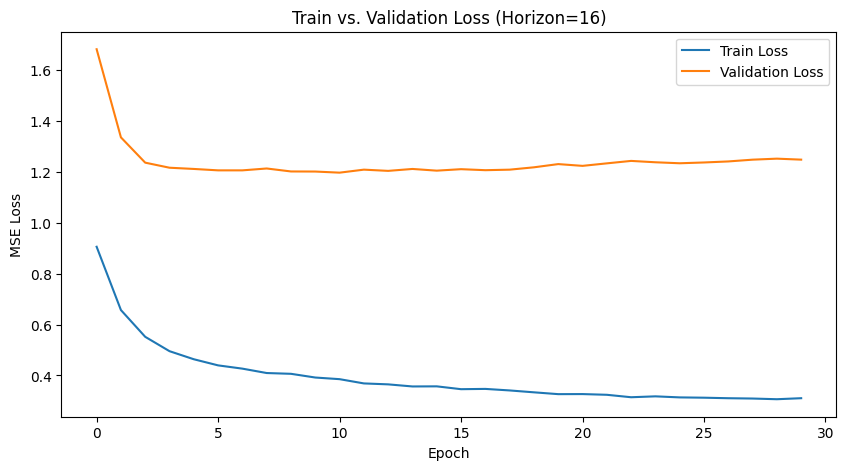

Site: site-1, Test MAE (Horizon 16): 0.3715
Site: site-10, Test MAE (Horizon 16): 0.5118
Site: site-11, Test MAE (Horizon 16): 0.3782
Site: site-12, Test MAE (Horizon 16): 0.5859
Site: site-2, Test MAE (Horizon 16): 0.3428
Site: site-3, Test MAE (Horizon 16): 0.3621
Site: site-4, Test MAE (Horizon 16): 0.4909
Site: site-5, Test MAE (Horizon 16): 0.3954
Site: site-6, Test MAE (Horizon 16): 0.3664
Site: site-7, Test MAE (Horizon 16): 0.4239
Site: site-8, Test MAE (Horizon 16): 0.5497
Site: site-9, Test MAE (Horizon 16): 0.5205

Average MAE across all sites (Horizon 16): 0.4416
✅ Results saved to forecasting_results.json

Running experiments for dataset: ../processed_ds/solar/

Starting experiment for horizon: 1
Site: solar_al | Train: 1328 | Validation: 332 | Test: 415
Site: solar_fl | Train: 1328 | Validation: 332 | Test: 415
Site: solar_il | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ks | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ma | Train: 1328 | Validation: 33

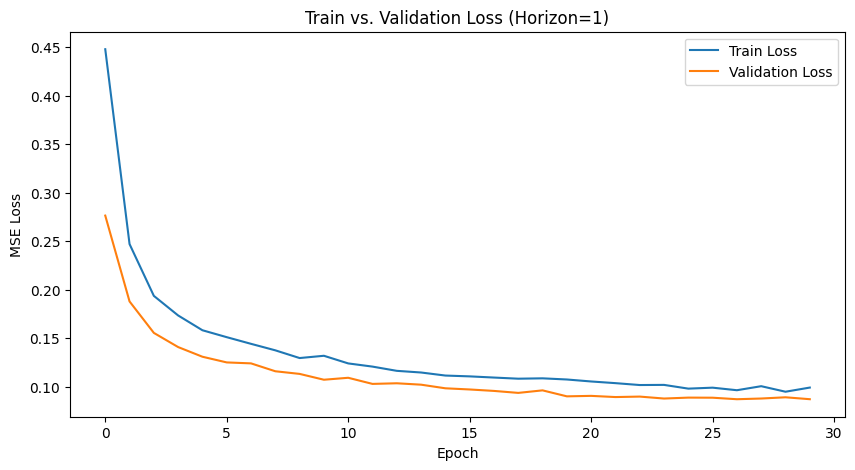

Site: solar_al, Test MAE (Horizon 1): 0.1553
Site: solar_fl, Test MAE (Horizon 1): 0.1872
Site: solar_il, Test MAE (Horizon 1): 0.1123
Site: solar_ks, Test MAE (Horizon 1): 0.1828
Site: solar_ma, Test MAE (Horizon 1): 0.2068
Site: solar_me, Test MAE (Horizon 1): 0.2012

Average MAE across all sites (Horizon 1): 0.1743
✅ Results saved to forecasting_results.json

Starting experiment for horizon: 2
Site: solar_al | Train: 1328 | Validation: 332 | Test: 415
Site: solar_fl | Train: 1328 | Validation: 332 | Test: 415
Site: solar_il | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ks | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ma | Train: 1328 | Validation: 332 | Test: 415
Site: solar_me | Train: 1328 | Validation: 332 | Test: 415
data loader length: [40, 40, 40, 40, 40, 40]
max dataloader length: 40 epoch iteration: 240
Epoch 1/30 for horizon 2
Epoch 1 | Train Loss: 0.7001 | Val Loss: 0.4591
Epoch 2/30 for horizon 2
Epoch 2 | Train Loss: 0.3650 | Val Loss: 0.3123
Epoch 3/

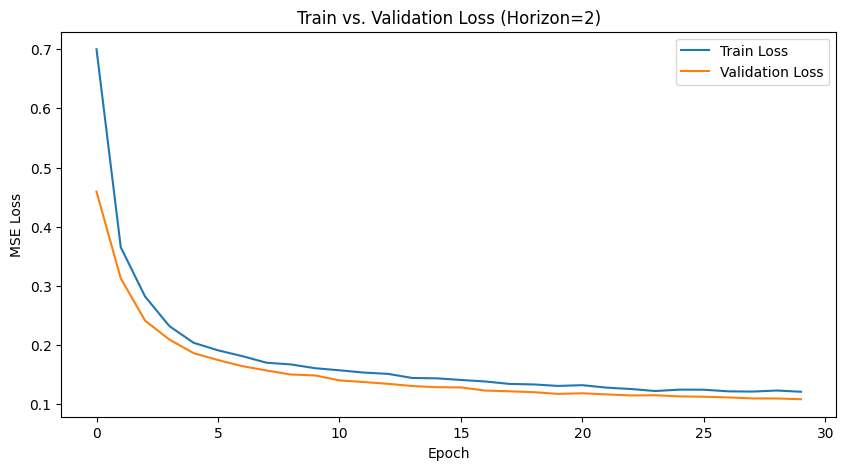

Site: solar_al, Test MAE (Horizon 2): 0.1700
Site: solar_fl, Test MAE (Horizon 2): 0.1653
Site: solar_il, Test MAE (Horizon 2): 0.1242
Site: solar_ks, Test MAE (Horizon 2): 0.1743
Site: solar_ma, Test MAE (Horizon 2): 0.2430
Site: solar_me, Test MAE (Horizon 2): 0.2136

Average MAE across all sites (Horizon 2): 0.1817
✅ Results saved to forecasting_results.json

Starting experiment for horizon: 4
Site: solar_al | Train: 1328 | Validation: 332 | Test: 415
Site: solar_fl | Train: 1328 | Validation: 332 | Test: 415
Site: solar_il | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ks | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ma | Train: 1328 | Validation: 332 | Test: 415
Site: solar_me | Train: 1328 | Validation: 332 | Test: 415
data loader length: [40, 40, 40, 40, 40, 40]
max dataloader length: 40 epoch iteration: 240
Epoch 1/30 for horizon 4
Epoch 1 | Train Loss: 0.5847 | Val Loss: 0.4311
Epoch 2/30 for horizon 4
Epoch 2 | Train Loss: 0.3552 | Val Loss: 0.3177
Epoch 3/

KeyboardInterrupt: 

In [24]:
run_global_model_experiment()